In [1]:
# import dependencies
!pip install -q sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from sklearn.model_selection import train_test_split
from scipy import stats
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0-rc2


In [2]:
!wget https://raw.githubusercontent.com/bangkitjkt/bangkit-1/master/data/mobilbekas.csv
df = pd.read_csv('mobilbekas.csv')

--2020-04-12 04:37:54--  https://raw.githubusercontent.com/bangkitjkt/bangkit-1/master/data/mobilbekas.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2588934 (2.5M) [text/plain]
Saving to: ‘mobilbekas.csv.1’

mobilbekas.csv.1    100%[===================>]   2.47M  --.-KB/s    in 0.1s    

2020-04-12 04:37:55 (24.7 MB/s) - ‘mobilbekas.csv.1’ saved [2588934/2588934]



In [3]:
df.shape

(14657, 16)

In [4]:
df.head()

,Harga,Lokasi,Penjual,Merek,Model,Varian,Tahun,Jarak tempuh,Tipe bahan bakar,Warna,Transmisi,Tipe bodi,Kapasitas mesin,Tipe Penjual,Sistem Penggerak,Nama Bursa Mobil
0,155000792,"Ngaliyan, Semarang Kota, Jawa Tengah",Tegar Ranisdya,BMW,Serie 3,320i Business Edition,2006,85.000-90.000 km,Bensin,Hitam,Automatic,Sedan,>1.500 - 2.000 cc,Individu,NaN,NaN
1,56000000,"Medan Johor, Medan Kota, Sumatra Utara",Anda Syahwilhanto,Hyundai,Getz,Lain-lain,2005,0-5.000 km,Bensin,Biru,Manual,Hatchback,>1.000 - 1.500 cc,Individu,Front Wheel Drive (FWD),NaN
2,120000000,"Ilir Timur I, Palembang Kota, Sumatra Selatan",alvianistm,Isuzu,Grand touring,Lain-lain,2004,10.000-15.000 km,Diesel,Silver,Manual,NaN,NaN,Individu,NaN,NaN
3,169000000,"Balerejo, Madiun Kab., Jawa Timur",PUSAT MOBIL BEKAS SIDOARJO,Isuzu,Grand touring,Lain-lain,2010,100.000-105.000 km,Diesel,Coklat,Manual,Minibus,>2.000 - 3.000 cc,Diler,NaN,NaN
4,120000000,"Kemayoran, Jakarta Pusat, Jakarta D.K.I.",Kristian,Proton,Lain-lain,Lain-lain,2010,75.000-80.000 km,Bensin,Oranye,Manual,Pick-up,>1.500 - 2.000 cc,NaN,Rear Wheel Drive (RWD),Pasar Mobil Kemayoran


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14657 entries, 0 to 14656
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Harga             14657 non-null  int64 
 1   Lokasi            14657 non-null  object
 2   Penjual           14657 non-null  object
 3   Merek             14657 non-null  object
 4   Model             14657 non-null  object
 5   Varian            13941 non-null  object
 6   Tahun             14657 non-null  object
 7   Jarak tempuh      14657 non-null  object
 8   Tipe bahan bakar  14657 non-null  object
 9   Warna             14657 non-null  object
 10  Transmisi         14657 non-null  object
 11  Tipe bodi         12491 non-null  object
 12  Kapasitas mesin   12859 non-null  object
 13  Tipe Penjual      12175 non-null  object
 14  Sistem Penggerak  11488 non-null  object
 15  Nama Bursa Mobil  2547 non-null   object
dtypes: int64(1), object(15)
memory usage: 1.8+ MB


In [6]:
df.isnull().sum()

Harga                   0
Lokasi                  0
Penjual                 0
Merek                   0
Model                   0
Varian                716
Tahun                   0
Jarak tempuh            0
Tipe bahan bakar        0
Warna                   0
Transmisi               0
Tipe bodi            2166
Kapasitas mesin      1798
Tipe Penjual         2482
Sistem Penggerak     3169
Nama Bursa Mobil    12110
dtype: int64

In [7]:
# Display the statistic for column 'Harga'
df.describe()

,Harga
count,1.465700e+04
mean,2.479546e+08
std,5.613904e+08
min,6.000000e+06
25%,8.000000e+07
50%,1.225000e+08
75%,2.160000e+08
max,1.700000e+10


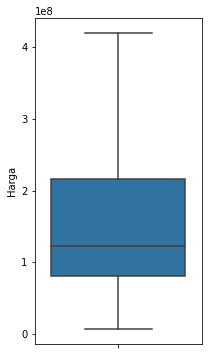

In [8]:
# display boxplot
plt.figure(figsize=(3,6))
sns.boxplot(y='Harga', data=df,showfliers=False);

In [9]:
# Drop outliers grouped by 'Model'

outlier_params = {}
model_set = set()
indexes = []

for item in df['Model']:
    model_set.add(item)

for model in model_set:
    model_df = df.loc[df['Model'] == model]
    param = [model_df['Harga'].mean(),
             model_df['Harga'].std() + 1]
    
    outlier_params[model] = param

for index, row in df.iterrows():
    # Calculate Z-score then group index whose value >=3
    if (np.abs((row['Harga'] - outlier_params[row['Model']][0]) / outlier_params[row['Model']][1]) >= 3):
        indexes.append(index)

print(len(indexes))
df = df.drop(index=indexes) # Remove rows with Z-score >=3

print(df.shape)

105
(14552, 16)


In [10]:
# Drop outliers in general
indexes = []

for index, row in df.iterrows():
    # Calculate Z-score then group index whose value >=3
    if (np.abs((row['Harga'] - df['Harga'].mean()) / df['Harga'].std()) >= 3):
        indexes.append(index)

print(len(indexes))
df = df.drop(index=indexes) # Remove rows with Z-score >=3

print(df.shape)

169
(14383, 16)


In [0]:
# Fill NaN values by modus of corresponding model


model_nan_filler = {}
model_set = set()

for item in df['Model']:
    model_set.add(item)

for model in model_set:
    model_df = df.loc[df['Model'] == model]
    filler = [stats.mode(model_df['Kapasitas mesin'])[0][0],
              stats.mode(model_df['Sistem Penggerak'])[0][0],
              stats.mode(model_df['Tipe bodi'])[0][0],
              stats.mode(model_df['Tipe Penjual'])[0][0],
              stats.mode(model_df['Varian'])[0][0]]
    
    model_nan_filler[model] = filler

for index, row in df.iterrows():
    if row['Kapasitas mesin'] == 'nan' :
        df.at[index, 'Kapasitas mesin'] = model_nan_filler[row['Model']][0]
    if row['Sistem Penggerak'] is np.nan:
        df.at[index, 'Sistem Penggerak'] = model_nan_filler[row['Model']][1]
    if row['Tipe bodi'] is np.nan:
        df.at[index, 'Tipe bodi'] = model_nan_filler[row['Model']][2]
    if row['Tipe Penjual'] is np.nan:
        df.at[index, 'Tipe Penjual'] = model_nan_filler[row['Model']][3]
    if row['Varian'] is np.nan:
        df.at[index, 'Varian'] = model_nan_filler[row['Model']][4]

df['Kapasitas mesin'] = df['Kapasitas mesin'].astype('str')

In [12]:
df['Harga'].isnull().sum()

0

In [0]:
# Separate lokasi into three columns ('Kecamatan', 'Kabupaten', 'Provinsi')

location = []
for index, row in df.iterrows():
    location.append(row['Lokasi'].split(', '))

location = pd.DataFrame(location)
location = location.drop([0, 2], axis=1) # Drop columns 'Kecamatan' and 'Provinsi'
location.rename(columns={1:'Kota/Kab'}, inplace=True) # Rename a column
df = pd.concat([df, location], axis=1) # Concate with the whole dataframe

In [0]:
df = df.drop(['Lokasi'], axis=1) # Drop column 'Lokasi'

In [15]:
df['Kota/Kab'].isnull().sum()

271

In [16]:
df['Merek'].isnull().sum()

271

In [0]:
# Drop column 'Penjual', 'Varian', 'Tipe bodi', and 'Nama Bursa Mobil'
# df = df.drop(['Penjual', 'Varian', 'Tipe bodi', 'Nama Bursa Mobil'], axis=1) 
# df = df.drop(['Penjual', 'Varian', 'Tipe bodi', 'Nama Bursa Mobil', 'Tipe bahan bakar', 'Warna', 'Transmisi', 'Tipe Penjual', 'Sistem Penggerak'], axis=1) 
df = df.drop(['Penjual', 'Varian', 'Tipe bodi', 'Nama Bursa Mobil'], axis=1) 

In [18]:
df.head()

,Harga,Merek,Model,Tahun,Jarak tempuh,Tipe bahan bakar,Warna,Transmisi,Kapasitas mesin,Tipe Penjual,Sistem Penggerak,Kota/Kab
0,155000792.0,BMW,Serie 3,2006,85.000-90.000 km,Bensin,Hitam,Automatic,>1.500 - 2.000 cc,Individu,Rear Wheel Drive (RWD),Semarang Kota
1,56000000.0,Hyundai,Getz,2005,0-5.000 km,Bensin,Biru,Manual,>1.000 - 1.500 cc,Individu,Front Wheel Drive (FWD),Medan Kota
2,120000000.0,Isuzu,Grand touring,2004,10.000-15.000 km,Diesel,Silver,Manual,nan,Individu,4X2,Palembang Kota
3,169000000.0,Isuzu,Grand touring,2010,100.000-105.000 km,Diesel,Coklat,Manual,>2.000 - 3.000 cc,Diler,4X2,Madiun Kab.
4,120000000.0,Proton,Lain-lain,2010,75.000-80.000 km,Bensin,Oranye,Manual,>1.500 - 2.000 cc,Individu,Rear Wheel Drive (RWD),Jakarta Pusat


In [19]:
# Drop rows that have any NaN values
df = df.dropna()
print(df.shape)
df.head(100)

(14112, 12)


,Harga,Merek,Model,Tahun,Jarak tempuh,Tipe bahan bakar,Warna,Transmisi,Kapasitas mesin,Tipe Penjual,Sistem Penggerak,Kota/Kab
0,1.550008e+08,BMW,Serie 3,2006,85.000-90.000 km,Bensin,Hitam,Automatic,>1.500 - 2.000 cc,Individu,Rear Wheel Drive (RWD),Semarang Kota
1,5.600000e+07,Hyundai,Getz,2005,0-5.000 km,Bensin,Biru,Manual,>1.000 - 1.500 cc,Individu,Front Wheel Drive (FWD),Medan Kota
2,1.200000e+08,Isuzu,Grand touring,2004,10.000-15.000 km,Diesel,Silver,Manual,nan,Individu,4X2,Palembang Kota
3,1.690000e+08,Isuzu,Grand touring,2010,100.000-105.000 km,Diesel,Coklat,Manual,>2.000 - 3.000 cc,Diler,4X2,Madiun Kab.
4,1.200000e+08,Proton,Lain-lain,2010,75.000-80.000 km,Bensin,Oranye,Manual,>1.500 - 2.000 cc,Individu,Rear Wheel Drive (RWD),Jakarta Pusat
...,...,...,...,...,...,...,...,...,...,...,...,...
99,1.200000e+09,Fiat,Abart,2017,0-5.000 km,Bensin,Kuning,Manual,>1.000 - 1.500 cc,Diler,Front Wheel Drive (FWD),Jakarta Selatan
100,8.299998e+07,Datsun,Go,2017,35.000-40.000 km,Bensin,Abu-abu,Manual,>1.000 - 1.500 cc,Individu,Front Wheel Drive (FWD),Jakarta Timur
101,2.350000e+08,Chevrolet,Trax,2018,20.000-25.000 km,Hybrid,Hitam,Automatic,>1.000 - 1.500 cc,Individu,4X2,Makassar Kota
102,2.350000e+08,Mitsubishi,Xpander,2018,15.000-20.000 km,Bensin,Putih,Automatic Triptonic,nan,Individu,4X2,Jakarta Timur


In [20]:
# Drop rows with value other than '>' and '<' in column 'Kapasitas Mesin'
indexes = []

for index, row in df.iterrows():
    if row['Kapasitas mesin'][0] != '>' and row['Kapasitas mesin'][0] != '<':
        indexes.append(index)
        
print(indexes)
df = df.drop(indexes)

# Drop rows with value 0 in columns 'Sistem Penggerak' and 'Tipe Penjual'
indexes = []

for index, row in df.iterrows():
    if row['Sistem Penggerak'] == 0 or row['Tipe Penjual'] == 0:
        indexes.append(index)
        
print(indexes)
df = df.drop(indexes)

print(df.shape)

[2, 5, 14, 16, 19, 20, 22, 23, 27, 28, 41, 43, 50, 62, 72, 76, 77, 98, 102, 103, 107, 113, 129, 147, 149, 155, 166, 175, 182, 211, 218, 228, 234, 241, 249, 271, 276, 280, 285, 287, 288, 290, 294, 299, 310, 322, 329, 336, 359, 360, 366, 375, 377, 379, 381, 393, 394, 395, 403, 416, 427, 445, 452, 462, 467, 471, 484, 496, 511, 516, 522, 525, 531, 536, 545, 572, 574, 581, 598, 610, 616, 617, 624, 639, 641, 649, 653, 656, 657, 664, 687, 698, 704, 715, 721, 723, 730, 740, 744, 746, 747, 753, 772, 781, 792, 801, 811, 836, 842, 857, 862, 876, 877, 879, 892, 907, 926, 928, 938, 944, 953, 955, 962, 989, 997, 1008, 1009, 1017, 1022, 1031, 1032, 1047, 1066, 1074, 1075, 1076, 1089, 1090, 1099, 1100, 1107, 1117, 1124, 1128, 1131, 1137, 1142, 1166, 1186, 1191, 1193, 1201, 1215, 1234, 1237, 1238, 1255, 1284, 1285, 1296, 1322, 1323, 1324, 1325, 1341, 1351, 1360, 1368, 1377, 1392, 1400, 1404, 1411, 1413, 1425, 1430, 1440, 1444, 1447, 1448, 1453, 1454, 1468, 1475, 1483, 1501, 1533, 1535, 1536, 1548, 1550

In [21]:
df.shape

(12405, 12)

In [22]:
# Turn 'Jarak tempuh' and 'Kapasitas mesin' to numerical data
for index, row in df.iterrows():
    df.at[index, 'Jarak tempuh'] = row['Jarak tempuh'].split('-')[-1].replace(' km', '').replace('<', '').replace('>', '')
    
    df.at[index, 'Kapasitas mesin'] = row['Kapasitas mesin'].split('-')[-1][1:].replace(' cc', '')

df.head()

,Harga,Merek,Model,Tahun,Jarak tempuh,Tipe bahan bakar,Warna,Transmisi,Kapasitas mesin,Tipe Penjual,Sistem Penggerak,Kota/Kab
0,155000792.0,BMW,Serie 3,2006,90.000,Bensin,Hitam,Automatic,2.000,Individu,Rear Wheel Drive (RWD),Semarang Kota
1,56000000.0,Hyundai,Getz,2005,5.000,Bensin,Biru,Manual,1.500,Individu,Front Wheel Drive (FWD),Medan Kota
3,169000000.0,Isuzu,Grand touring,2010,105.000,Diesel,Coklat,Manual,3.000,Diler,4X2,Madiun Kab.
4,120000000.0,Proton,Lain-lain,2010,80.000,Bensin,Oranye,Manual,2.000,Individu,Rear Wheel Drive (RWD),Jakarta Pusat
6,420000000.0,Mercedes-Benz,SLK,2005,45.000,Bensin,Silver,Automatic,2.000,Individu,Rear Wheel Drive (RWD),Tangerang Selatan Kota


In [23]:
df.isnull().sum()

Harga               0
Merek               0
Model               0
Tahun               0
Jarak tempuh        0
Tipe bahan bakar    0
Warna               0
Transmisi           0
Kapasitas mesin     0
Tipe Penjual        0
Sistem Penggerak    0
Kota/Kab            0
dtype: int64

In [0]:
# df = df.rename(columns={"Merek": "merek", "Model": "model", "Tahun": "tahun", 
#                         "Jarak tempuh": "jarak_tempuh", "Harga": "harga",
#                         "Kapasitas mesin": "kapasitas_mesin", "Kota/Kab": "kota"})
df = df.rename(columns={"Merek": "merek", "Model": "model", "Tahun": "tahun", 
                        "Jarak tempuh": "jarak_tempuh", "Tipe bahan bakar": "tipe_bahan_bakar", 
                        "Warna": "warna", "Transmisi": "transmisi", "Harga": "harga",
                        "Kapasitas mesin": "kapasitas_mesin", "Tipe Penjual": "tipe_penjual", 
                        "Sistem Penggerak": "sistem_penggerak", "Kota/Kab": "kota"})

In [25]:
from sklearn.preprocessing import minmax_scale
# df = df.drop(['sistem_penggerak'], axis=1)
df.head()

# scale harga
df['harga'] /= 1000000

# scale minmax
df['jarak_tempuh'] = minmax_scale(df['jarak_tempuh'])
df['kapasitas_mesin'] = minmax_scale(df['kapasitas_mesin'])
df['tahun'].replace('<1986', 1986, inplace=True)
df['tahun'] = minmax_scale(df['tahun'])

df.head()

,harga,merek,model,tahun,jarak_tempuh,tipe_bahan_bakar,warna,transmisi,kapasitas_mesin,tipe_penjual,sistem_penggerak,kota
0,155.000792,BMW,Serie 3,0.606061,0.288136,Bensin,Hitam,Automatic,0.50,Individu,Rear Wheel Drive (RWD),Semarang Kota
1,56.000000,Hyundai,Getz,0.575758,0.000000,Bensin,Biru,Manual,0.25,Individu,Front Wheel Drive (FWD),Medan Kota
3,169.000000,Isuzu,Grand touring,0.727273,0.338983,Diesel,Coklat,Manual,1.00,Diler,4X2,Madiun Kab.
4,120.000000,Proton,Lain-lain,0.727273,0.254237,Bensin,Oranye,Manual,0.50,Individu,Rear Wheel Drive (RWD),Jakarta Pusat
6,420.000000,Mercedes-Benz,SLK,0.575758,0.135593,Bensin,Silver,Automatic,0.50,Individu,Rear Wheel Drive (RWD),Tangerang Selatan Kota


In [26]:
# Split the dataframe into train and test
train, test = train_test_split(df, test_size=0.2)
print(len(train), 'train examples')
print(len(test), 'test examples')

9924 train examples
2481 test examples


In [0]:
# Shuffle the examples
train = train.reindex(np.random.permutation(train.index))

In [28]:
train.head()

,harga,merek,model,tahun,jarak_tempuh,tipe_bahan_bakar,warna,transmisi,kapasitas_mesin,tipe_penjual,sistem_penggerak,kota
692,134.2,Daihatsu,Gran max Pick-up,0.969697,0.118644,Bensin,Abu-abu,Manual,0.25,Individu,4X2,Jakarta Barat
12271,88.0,Suzuki,Swift,0.666667,0.372881,Bensin,Biru,Automatic,0.25,Individu,4X2,Pekanbaru Kota
6711,32.5,Mazda,Lain-lain,0.121212,0.915254,Bensin,Abu-abu,Manual,0.50,Individu,Front Wheel Drive (FWD),Tangerang Selatan Kota
10469,74.0,Mazda,5,0.575758,0.813559,Bensin,Coklat,Automatic,0.25,Diler,Front Wheel Drive (FWD),Tangerang Selatan Kota
535,128.0,Nissan,Juke,0.787879,0.135593,Bensin,Silver,Automatic Triptonic,0.25,Diler,4X2,Palembang Kota


In [29]:
train.columns

Index(['harga', 'merek', 'model', 'tahun', 'jarak_tempuh', 'tipe_bahan_bakar',
       'warna', 'transmisi', 'kapasitas_mesin', 'tipe_penjual',
       'sistem_penggerak', 'kota'],
      dtype='object')

In [30]:
train.head()

,harga,merek,model,tahun,jarak_tempuh,tipe_bahan_bakar,warna,transmisi,kapasitas_mesin,tipe_penjual,sistem_penggerak,kota
692,134.2,Daihatsu,Gran max Pick-up,0.969697,0.118644,Bensin,Abu-abu,Manual,0.25,Individu,4X2,Jakarta Barat
12271,88.0,Suzuki,Swift,0.666667,0.372881,Bensin,Biru,Automatic,0.25,Individu,4X2,Pekanbaru Kota
6711,32.5,Mazda,Lain-lain,0.121212,0.915254,Bensin,Abu-abu,Manual,0.50,Individu,Front Wheel Drive (FWD),Tangerang Selatan Kota
10469,74.0,Mazda,5,0.575758,0.813559,Bensin,Coklat,Automatic,0.25,Diler,Front Wheel Drive (FWD),Tangerang Selatan Kota
535,128.0,Nissan,Juke,0.787879,0.135593,Bensin,Silver,Automatic Triptonic,0.25,Diler,4X2,Palembang Kota


In [0]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
tahun = tf.feature_column.numeric_column("tahun")
feature_columns.append(tahun)

# Create a numerical feature column to represent jarak tempuh.
jarak_tempuh = tf.feature_column.numeric_column("jarak_tempuh")
feature_columns.append(jarak_tempuh)

# Create a numerical feature column to represent kapasitas mesin.
kapasitas_mesin = tf.feature_column.numeric_column("kapasitas_mesin")
feature_columns.append(kapasitas_mesin)

In [32]:
df['merek'].unique()

array(['BMW', 'Hyundai', 'Isuzu', 'Proton', 'Mercedes-Benz', 'KIA',
       'Smart', 'Mitsubishi', 'Mazda', 'Chery', 'Volkswagen', 'Toyota',
       'Peugeot', 'Lexus', 'Audi', 'Honda', 'Nissan', 'Jeep', 'Suzuki',
       'Daihatsu', 'Citroen', 'Datsun', 'Geely', 'Dodge', 'Mini Cooper',
       'Chevrolet', 'Jaguar', 'Fiat', 'Land Rover', 'Ford', 'Volvo',
       'Hino', 'Porsche', 'Wuling', 'Holden', 'Klasik dan Antik',
       'Lain-lain', 'Renault', 'Timor', 'Maserati', 'Cadillac', 'Subaru',
       'Tata', 'Aston Martin', 'Opel', 'Chrysler', 'Infiniti',
       'Mobil CBU', 'Foton', 'Ssang Yong', 'Daewoo',
       'DFSK (Dongfeng Sokon)', 'Hummer'], dtype=object)

In [0]:
# Create a categorical feature column to represent merek.
merek = feature_column.categorical_column_with_vocabulary_list(
      'merek', df['merek'].unique())
merek_one_hot = feature_column.indicator_column(merek)
feature_columns.append(merek_one_hot)

# Create a categorical feature column to represent model.
model = feature_column.categorical_column_with_vocabulary_list(
        'model', df['model'].unique())
model_one_hot = feature_column.indicator_column(model)
feature_columns.append(model_one_hot)

# # Create a categorical feature column to represent tipe bahan bakar.
tipebahanbakar = feature_column.categorical_column_with_vocabulary_list(
                 'tipe_bahan_bakar', df['tipe_bahan_bakar'].unique())
tipebahanbakar_one_hot = feature_column.indicator_column(tipebahanbakar)
feature_columns.append(tipebahanbakar_one_hot)

# # Create a categorical feature column to represent warna.
warna = feature_column.categorical_column_with_vocabulary_list(
        'warna', df['warna'].unique())
warna_one_hot = feature_column.indicator_column(warna)
feature_columns.append(warna_one_hot)

# Create a categorical feature column to represent transmisi.
transmisi = feature_column.categorical_column_with_vocabulary_list(
            'transmisi', df['transmisi'].unique())
transmisi_one_hot = feature_column.indicator_column(transmisi)
feature_columns.append(transmisi_one_hot)

# # Create a categorical feature column to represent tipe penjual.
tipepenjual = feature_column.categorical_column_with_vocabulary_list(
              'tipe_penjual', df['tipe_penjual'].unique())
tipepenjual_one_hot = feature_column.indicator_column(tipepenjual)
feature_columns.append(tipepenjual_one_hot)

# Create a categorical feature column to represent sistem penggerak.
sistempenggerak = feature_column.categorical_column_with_vocabulary_list(
                  'sistem_penggerak', df['sistem_penggerak'].unique())
sistempenggerak_one_hot = feature_column.indicator_column(sistempenggerak)
feature_columns.append(sistempenggerak_one_hot)

# # Create a categorical feature column to represent kota/kab.
kota = feature_column.categorical_column_with_vocabulary_list(
       'kota', df['kota'].unique())
kota_one_hot = feature_column.indicator_column(kota)
feature_columns.append(kota_one_hot)

In [34]:
feature_columns

[NumericColumn(key='tahun', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='jarak_tempuh', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='kapasitas_mesin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='merek', vocabulary_list=('BMW', 'Hyundai', 'Isuzu', 'Proton', 'Mercedes-Benz', 'KIA', 'Smart', 'Mitsubishi', 'Mazda', 'Chery', 'Volkswagen', 'Toyota', 'Peugeot', 'Lexus', 'Audi', 'Honda', 'Nissan', 'Jeep', 'Suzuki', 'Daihatsu', 'Citroen', 'Datsun', 'Geely', 'Dodge', 'Mini Cooper', 'Chevrolet', 'Jaguar', 'Fiat', 'Land Rover', 'Ford', 'Volvo', 'Hino', 'Porsche', 'Wuling', 'Holden', 'Klasik dan Antik', 'Lain-lain', 'Renault', 'Timor', 'Maserati', 'Cadillac', 'Subaru', 'Tata', 'Aston Martin', 'Opel', 'Chrysler', 'Infiniti', 'Mobil CBU', 'Foton', 'Ssang Yong', 'Daewoo', 'DFSK (Dongfeng Sokon)', 'Hummer'), dtype

In [0]:
# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [36]:
train.columns

Index(['harga', 'merek', 'model', 'tahun', 'jarak_tempuh', 'tipe_bahan_bakar',
       'warna', 'transmisi', 'kapasitas_mesin', 'tipe_penjual',
       'sistem_penggerak', 'kota'],
      dtype='object')

In [37]:
feature_columns

[NumericColumn(key='tahun', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='jarak_tempuh', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='kapasitas_mesin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='merek', vocabulary_list=('BMW', 'Hyundai', 'Isuzu', 'Proton', 'Mercedes-Benz', 'KIA', 'Smart', 'Mitsubishi', 'Mazda', 'Chery', 'Volkswagen', 'Toyota', 'Peugeot', 'Lexus', 'Audi', 'Honda', 'Nissan', 'Jeep', 'Suzuki', 'Daihatsu', 'Citroen', 'Datsun', 'Geely', 'Dodge', 'Mini Cooper', 'Chevrolet', 'Jaguar', 'Fiat', 'Land Rover', 'Ford', 'Volvo', 'Hino', 'Porsche', 'Wuling', 'Holden', 'Klasik dan Antik', 'Lain-lain', 'Renault', 'Timor', 'Maserati', 'Cadillac', 'Subaru', 'Tata', 'Aston Martin', 'Opel', 'Chrysler', 'Infiniti', 'Mobil CBU', 'Foton', 'Ssang Yong', 'Daewoo', 'DFSK (Dongfeng Sokon)', 'Hummer'), dtype

In [0]:
# Define a deep neural net model

def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 100 nodes.   
  model.add(tf.keras.layers.Dense(units=100, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 10 nodes.   
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [0]:
# Define a training function

def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=2) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

In [40]:
# Define the plotting function.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [41]:
train.head()

,harga,merek,model,tahun,jarak_tempuh,tipe_bahan_bakar,warna,transmisi,kapasitas_mesin,tipe_penjual,sistem_penggerak,kota
692,134.2,Daihatsu,Gran max Pick-up,0.969697,0.118644,Bensin,Abu-abu,Manual,0.25,Individu,4X2,Jakarta Barat
12271,88.0,Suzuki,Swift,0.666667,0.372881,Bensin,Biru,Automatic,0.25,Individu,4X2,Pekanbaru Kota
6711,32.5,Mazda,Lain-lain,0.121212,0.915254,Bensin,Abu-abu,Manual,0.50,Individu,Front Wheel Drive (FWD),Tangerang Selatan Kota
10469,74.0,Mazda,5,0.575758,0.813559,Bensin,Coklat,Automatic,0.25,Diler,Front Wheel Drive (FWD),Tangerang Selatan Kota
535,128.0,Nissan,Juke,0.787879,0.135593,Bensin,Silver,Automatic Triptonic,0.25,Diler,4X2,Palembang Kota


Streaming output truncated to the last 5000 lines.
20/20 - 0s - loss: 2516.0078 - mean_squared_error: 2515.4795
Epoch 3502/6000
20/20 - 0s - loss: 2512.1536 - mean_squared_error: 2514.8276
Epoch 3503/6000
20/20 - 0s - loss: 2503.5315 - mean_squared_error: 2513.3945
Epoch 3504/6000
20/20 - 0s - loss: 2506.0559 - mean_squared_error: 2512.1562
Epoch 3505/6000
20/20 - 0s - loss: 2504.6746 - mean_squared_error: 2513.0198
Epoch 3506/6000
20/20 - 0s - loss: 2507.0984 - mean_squared_error: 2512.3516
Epoch 3507/6000
20/20 - 0s - loss: 2511.4028 - mean_squared_error: 2512.9785
Epoch 3508/6000
20/20 - 0s - loss: 2526.2104 - mean_squared_error: 2511.9934
Epoch 3509/6000
20/20 - 0s - loss: 2518.5774 - mean_squared_error: 2513.7268
Epoch 3510/6000
20/20 - 0s - loss: 2517.0107 - mean_squared_error: 2512.8022
Epoch 3511/6000
20/20 - 0s - loss: 2522.5173 - mean_squared_error: 2510.7810
Epoch 3512/6000
20/20 - 0s - loss: 2520.0903 - mean_squared_error: 2514.5027
Epoch 3513/6000
20/20 - 0s - loss: 2511.4

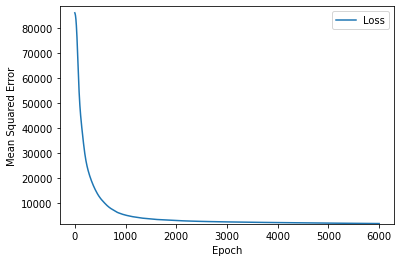


 Evaluate the new model against the test set:
5/5 [==============================] - 0s 4ms/step - loss: 6014.5010 - mean_squared_error: 6023.7026


[6014.5009765625, 6023.70263671875]

In [42]:
# Call the functions to build and train a deep neural net

# The following variables are the hyperparameters.
learning_rate = 0.0001
epochs = 6000
batch_size = 500

# Specify the label
label_name = "harga"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)


In [43]:
train.head()

,harga,merek,model,tahun,jarak_tempuh,tipe_bahan_bakar,warna,transmisi,kapasitas_mesin,tipe_penjual,sistem_penggerak,kota
692,134.2,Daihatsu,Gran max Pick-up,0.969697,0.118644,Bensin,Abu-abu,Manual,0.25,Individu,4X2,Jakarta Barat
12271,88.0,Suzuki,Swift,0.666667,0.372881,Bensin,Biru,Automatic,0.25,Individu,4X2,Pekanbaru Kota
6711,32.5,Mazda,Lain-lain,0.121212,0.915254,Bensin,Abu-abu,Manual,0.50,Individu,Front Wheel Drive (FWD),Tangerang Selatan Kota
10469,74.0,Mazda,5,0.575758,0.813559,Bensin,Coklat,Automatic,0.25,Diler,Front Wheel Drive (FWD),Tangerang Selatan Kota
535,128.0,Nissan,Juke,0.787879,0.135593,Bensin,Silver,Automatic Triptonic,0.25,Diler,4X2,Palembang Kota
